In [1]:
# 구글 드라이브 권한 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 모듈 불러오기
import os
import cv2
import numpy as np
from glob import glob
from os.path import join
from tqdm import tqdm
import torch
import torch.nn.functional as F
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt


In [ ]:
# GPU 사용설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 이미지 전처리

In [4]:
# 데이터셋 경로
train_folder = '/content/drive/MyDrive/hw4/train_ref'
test_folder = '/content/drive/MyDrive/hw4/test2'

# 확장자가 BMP인 데이터셋 리스트에 저장
train_list = (glob(join(train_folder, '*.BMP')))
test_list = (glob(join(test_folder, '*.BMP')))

In [5]:
train_image = []
test_image = []

for path in tqdm(train_list):
  train_image.append(cv2.imread(path, 0))


100%|██████████| 477/477 [00:08<00:00, 55.31it/s] 


In [14]:
for path in tqdm(test_list):
  test_image.append(cv2.imread(path, 0))

100%|██████████| 1428/1428 [08:06<00:00,  2.94it/s]


In [16]:
# 전처리 함수
def preprocess_image(image):

        # 노이즈 제거
        blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

        # 이진화
        binary_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        binary_image = 255 - binary_image
        binary_image = cv2.GaussianBlur(binary_image, (3, 3), 0)

        # skeletonization
        skeleton_image = skeletonize(binary_image // 255).astype(np.uint8) * 255

        return skeleton_image

이미지로 표현하기 위해 train_set[0]만 실행한 결과

In [7]:
blurred_test, binary_test, skeleton_test = preprocess_image(train_image[0])

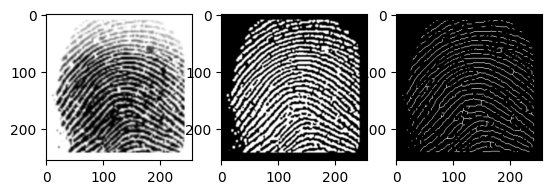

In [12]:
plt.subplot(1, 3, 1)
plt.imshow(blurred_test, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(binary_test, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(skeleton_test, cmap='gray')

전체 데이터셋 전처리 과정

In [17]:
# 이미지 리스트 전처리
def preprocess_image_list(image_list):
    preprocessed_images = []
    for image in image_list:
        preprocessed_image = preprocess_image(image)
        preprocessed_images.append(preprocessed_image)
    return preprocessed_images

In [18]:
train_image_preprocessed = preprocess_image_list(train_image)
test_image_preprocessed = preprocess_image_list(test_image)

## 특징 추출

In [39]:
def add_contours_to_image(image):
    # 모폴로지 연산 (팽창 후 침식)
    kernel = np.ones((3, 3), np.uint8)
    morphed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    # 컨투어 찾기
    contours, _ = cv2.findContours(morphed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 컨투어 그리기
    contour_image = cv2.drawContours(image.copy(), contours, -1, (255, 255, 255), 1)

    return contour_image

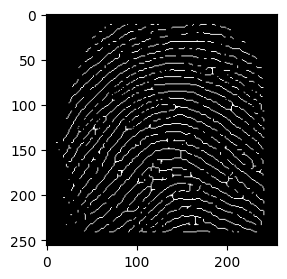

In [41]:
train_image_with_contours = [add_contours_to_image(img) for img in train_image_preprocessed]
test_image_with_contours = [add_contours_to_image(img) for img in test_image_preprocessed]

# 시각화를 위한 값
example = train_image_with_contours[0]

plt.figure(figsize=(3, 3))
plt.imshow(example, cmap='gray')
plt.show()

In [51]:
def extract_minutiae_features(skeleton_image):
    rows, cols = skeleton_image.shape
    minutiae_points = []

    # 3x3 윈도우 설정
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if skeleton_image[i, j] == 255:  # 흰색 픽셀만 고려
                # 3x3 영역 추출
                window = skeleton_image[i-1:i+2, j-1:j+2]
                # 중앙 픽셀 제외한 흰색 픽셀의 개수 세기
                white_pixels = np.sum(window) // 255 - 1

                if white_pixels == 1:  # 끝점
                    minutiae_points.append((i, j, 'end'))
                elif white_pixels == 3:  # 분기점
                    minutiae_points.append((i, j, 'bif'))

    return minutiae_points

In [52]:
# 전처리된 이미지에 대해 특징 추출 실행
train_features = [extract_minutiae_features(img) for img in train_image_with_contours]
test_features = [extract_minutiae_features(img) for img in test_image_with_contours]

In [53]:
# 추출된 특징 중 하나를 출력해보기
print(train_features[0])

[(11, 71, 'end'), (11, 72, 'end'), (11, 99, 'end'), (11, 100, 'end'), (11, 116, 'end'), (11, 119, 'end'), (11, 123, 'end'), (11, 124, 'end'), (11, 163, 'end'), (11, 177, 'end'), (11, 184, 'end'), (12, 87, 'end'), (12, 156, 'end'), (12, 162, 'end'), (12, 170, 'end'), (12, 187, 'end'), (13, 193, 'end'), (14, 65, 'end'), (14, 110, 'end'), (15, 65, 'end'), (15, 139, 'end'), (15, 199, 'end'), (16, 201, 'end'), (17, 102, 'end'), (17, 124, 'end'), (17, 132, 'end'), (17, 204, 'end'), (19, 59, 'end'), (19, 61, 'end'), (19, 96, 'end'), (19, 118, 'end'), (20, 167, 'end'), (20, 168, 'end'), (20, 174, 'end'), (21, 116, 'end'), (21, 156, 'end'), (22, 150, 'end'), (24, 54, 'end'), (24, 134, 'end'), (25, 126, 'end'), (25, 198, 'end'), (25, 204, 'end'), (26, 51, 'end'), (26, 99, 'end'), (27, 81, 'end'), (27, 115, 'end'), (27, 207, 'end'), (29, 92, 'end'), (29, 167, 'bif'), (30, 61, 'end'), (30, 74, 'end'), (30, 77, 'end'), (30, 106, 'end'), (30, 166, 'bif'), (30, 167, 'bif'), (30, 168, 'bif'), (30, 175

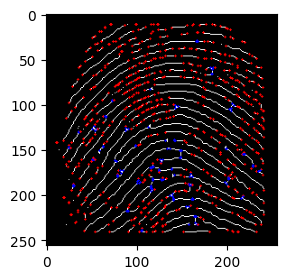

In [49]:
def visualize_minutiae(image, minutiae_points):
    # 색상 설정
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for (x, y, typ) in minutiae_points:
        if typ == 'ending':
            color = (0, 0, 255)  # 빨간색
        elif typ == 'bifurcation':
            color = (255, 0, 0)  # 초록색

        cv2.circle(color_image, (y, x), 1, color, -1)

    return color_image

# 하나의 예시 이미지와 그에 대한 특징 시각화
example_image = train_image_with_contours[0]
example_features = train_features[0]
visualized_image = visualize_minutiae(example_image, example_features)

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(visualized_image, cv2.COLOR_BGR2RGB))
plt.show()


## 매칭


In [54]:
import torch
from scipy.spatial import distance

def match_minutiae(features1, features2, threshold=10):
    matches = []
    for point1 in features1:
        for point2 in features2:
            if point1[2] == point2[2]:  # 같은 유형의 특징점만 매칭
                dist = distance.euclidean((point1[0], point1[1]), (point2[0], point2[1]))
                if dist <= threshold:
                    matches.append((point1, point2, dist))
    return matches

def match_all(train_features, test_features, threshold=10):
    all_matches = []
    for test_idx, test_feat in enumerate(test_features):
        test_matches = []
        for train_idx, train_feat in enumerate(train_features):
            matches = match_minutiae(train_feat, test_feat, threshold)
            test_matches.append((train_idx, matches))
        all_matches.append((test_idx, test_matches))
    return all_matches


In [68]:
sample_size = 30

In [70]:
def match_minutiae_pytorch(features1, features2, threshold=10):
    points1 = [(x, y) for x, y, _ in features1]
    points2 = [(x, y) for x, y, _ in features2]

    types1 = [t for _, _, t in features1]
    types2 = [t for _, _, t in features2]

    points1 = torch.tensor(points1, dtype=torch.float32)
    points2 = torch.tensor(points2, dtype=torch.float32)

    matches = []

    for i, type1 in enumerate(types1):
        same_type_indices = [j for j, type2 in enumerate(types2) if type1 == type2]
        if same_type_indices:
            sub_points2 = points2[same_type_indices]
            dists = torch.norm(points1[i] - sub_points2, dim=1)
            min_dist, min_idx = torch.min(dists, dim=0)
            if min_dist.item() <= threshold:
                matches.append((features1[i], features2[same_type_indices[min_idx]], min_dist.item()))

    return matches

def match_all_pytorch(train_features, test_features, threshold=10, sample_size=10):
    all_matches = []
    for test_idx, test_feat in enumerate(test_features[:sample_size]):
        test_matches = []
        for train_idx, train_feat in enumerate(train_features[:sample_size]):
            matches = match_minutiae_pytorch(train_feat, test_feat, threshold)
            test_matches.append((train_idx, matches))
        all_matches.append((test_idx, test_matches))
    return all_matches

In [71]:
all_matches = match_all_pytorch(train_features, test_features, 10, sample_size)

## Metrics

In [72]:
def calculate_metrics(all_matches, total_train):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for test_idx, test_matches in all_matches:
        matched_train_indices = [train_idx for train_idx, matches in test_matches if len(matches) > 0]

        if test_idx in matched_train_indices:
            true_positives += 1
        else:
            false_negatives += 1

        for train_idx in range(total_train):
            if train_idx != test_idx:
                if train_idx in matched_train_indices:
                    false_positives += 1
                else:
                    true_negatives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    far = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
    frr = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else 0
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0

    return precision, recall, far, frr, accuracy

In [77]:
precision, recall, far, frr, accuracy = calculate_metrics(all_matches, 5)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"FAR: {far:.4f}")
print(f"FRR: {frr:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.1714
Recall: 1.0000
FAR: 1.0000
FRR: 0.0000
Accuracy: 0.1714
